In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_obj
from PIL import Image, ImageDraw

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights, 
    Materials, 
    SoftPhongShader,
    HardPhongShader,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

print('python:', sys.version)
print('torch :', torch.__version__)
print('cuda  :', torch.version.cuda)
%load_ext autoreload
%autoreload 2

import sys, os
os.path.dirname(sys.executable)

[autoreload of pytorch3d.renderer.mesh.rasterize_meshes failed: Traceback (most recent call last):
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d0\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d0\lib\site-packages\IPython\extensions\autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d0\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d0\lib\site-packages\IPython\extensions\autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d0\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_gene

python: 3.8.2 (default, Apr 14 2020, 19:01:40) [MSC v.1916 64 bit (AMD64)]
torch : 1.4.0
cuda  : 10.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'C:\\Users\\hjoon\\AppData\\Local\\Continuum\\anaconda3\\envs\\pytorch3d0'

In [19]:
device = torch.device("cuda:0")
torch.cuda.set_device(device)

verts, faces_idx, _ = load_obj("./2_data/triangle.obj")
faces = faces_idx.verts_idx

verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

<IPython.core.display.Javascript object>


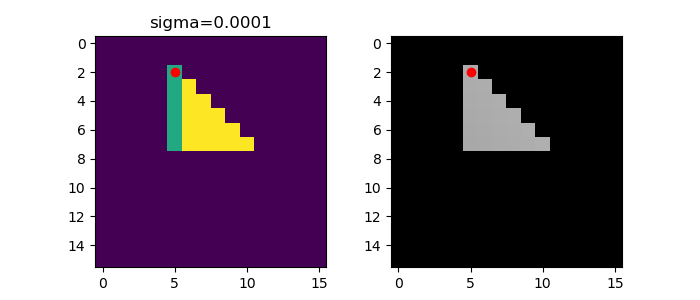

In [194]:
%matplotlib notebook
images = []

cameras = OpenGLPerspectiveCameras(device=device)

blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

raster_settings = RasterizationSettings(
    image_size=16, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=1, 
)

silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, lights=lights)
)
# Select the viewpoint using spherical angles  
distance = 2.1   # distance from camera to the object
elevation = 0.0   # angle of elevation in degrees
azimuth = 30.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

pi = np.array([5, 2])


plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.title('sigma={}'.format(blend_params.sigma))
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.scatter(pi[0], pi[1], c='r')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.scatter(pi[0], pi[1], c='r')
plt.show()

edge_function: (-0.82-0.00)*(0.82-0.00)-(0.00-0.00)*(0.00-0.00) = (-0.82)*(0.82)-(0.00)*(0.00) = -0.68
edge_function: (0.31-0.00)*(0.00-0.82)-(0.69-0.82)*(-0.82-0.00) = (0.31)*(-0.82)-(-0.14)*(-0.82) = -0.37
edge_function: (0.31--0.82)*(0.00-0.00)-(0.69-0.00)*(0.00--0.82) = (1.14)*(0.00)-(0.69)*(0.82) = -0.57
edge_function: (0.31-0.00)*(0.82-0.00)-(0.69-0.00)*(0.00-0.00) = (0.31)*(0.82)-(0.69)*(0.00) = 0.26
w0=0.55, w1=0.83, w2=-0.38
recovered=(0.31, 0.69, -0.04)


<IPython.core.display.Javascript object>


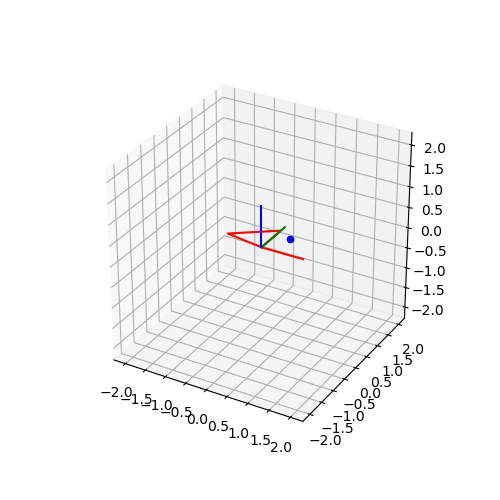

In [189]:
%matplotlib notebook

s = 16
x = 5
y = 2

xi = s - 1 - x
yi = s - 1 - y

xn = -1 + (2*xi+1)/s
yn = -1 + (2*yi+1)/s
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# ax[0].scatter(x, y, c='r')
# ax[0].set_xlim([0, 15]), ax[0].set_ylim([0, 15])
# ax[0].invert_yaxis()
# ax[0].set_title('({}, {})'.format(x, y))
# ax[1].scatter(xi, yi, c='r')
# ax[1].set_xlim([0, 15]), ax[1].set_ylim([0, 15])
# ax[1].invert_xaxis()
# ax[1].set_title('({}, {})'.format(xi, yi))
# ax[2].scatter(xn, yn, c='r')
# ax[2].set_xlim([-1, 1]), ax[2].set_ylim([-1, 1])
# ax[2].invert_xaxis()
# ax[2].set_title('({}, {})'.format(xn, yn))
# plt.show()

def edge_function(p, v0, v1):
    print('edge_function: ({:.2f}-{:.2f})*({:.2f}-{:.2f})-({:.2f}-{:.2f})*({:.2f}-{:.2f}) = ({:.2f})*({:.2f})-({:.2f})*({:.2f}) = {:.2f}'.format(p[0], v0[0], v1[1], v0[1], p[1], v0[1], v1[0], v0[0], (p[0] - v0[0]), (v1[1] - v0[1]), (p[1] - v0[1]), (v1[0] - v0[0]), (p[0] - v0[0]) * (v1[1] - v0[1]) - (p[1] - v0[1]) * (v1[0] - v0[0])))
    return (p[0] - v0[0]) * (v1[1] - v0[1]) - (p[1] - v0[1]) * (v1[0] - v0[0])
v0 = np.float32([0.0000, 0.0000, 0])
v1 = np.float32([0.0000, 0.8248, 0])
v2 = np.float32([-0.8248,  0.0000,  0.1])
p = np.float32([xn, yn])
kEpsilon = 1e-30
area = edge_function(v2, v0, v1) + kEpsilon  # 2 x face area.
w0 = edge_function(p, v1, v2) / area
w1 = edge_function(p, v2, v0) / area
w2 = edge_function(p, v0, v1) / area

print('w0={:.2f}, w1={:.2f}, w2={:.2f}'.format(w0, w1, w2))
x_recovered = w0*v0[0] + w1*v1[0] + w2*v2[0]
y_recovered = w0*v0[1] + w1*v1[1] + w2*v2[1]
z_recovered = w0*v0[2] + w1*v1[2] + w2*v2[2]
print('recovered=({:.2f}, {:.2f}, {:.2f})'.format(x_recovered, y_recovered, z_recovered))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
vs = np.stack([v0, v1, v2, v0])
ax.plot(vs[:,0], vs[:,1], vs[:,2], c='r')
L = 1
ax.plot([0, L], [0, 0], [0, 0], 'r')
ax.plot([0, 0], [0, L], [0, 0], 'g')
ax.plot([0, 0], [0, 0], [0, L], 'b')
ax.scatter(p[0], p[1], z_recovered, c='b')
L = 2.2
ax.set_xlim([-L, L])
ax.set_ylim([-L, L])
ax.set_zlim([-L, L])
plt.show()

# Zbuf

In [244]:
rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )
raster_settings = RasterizationSettings(
    image_size=32, 
    blur_radius=200*np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=2, 
)

fragments = rasterizer(mesh, raster_settings=raster_settings)

In [245]:
print(np.log(1. / 1e-4 - 1.) * blend_params.sigma)


0.000921024036697585


#### dists

(32, 32, 2)


<IPython.core.display.Javascript object>


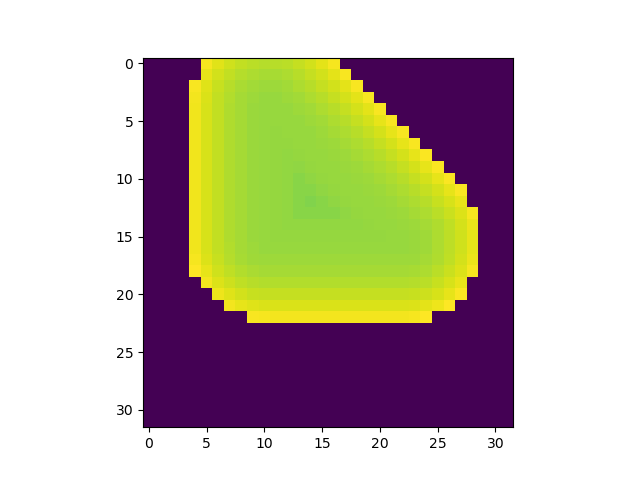

<IPython.core.display.Javascript object>


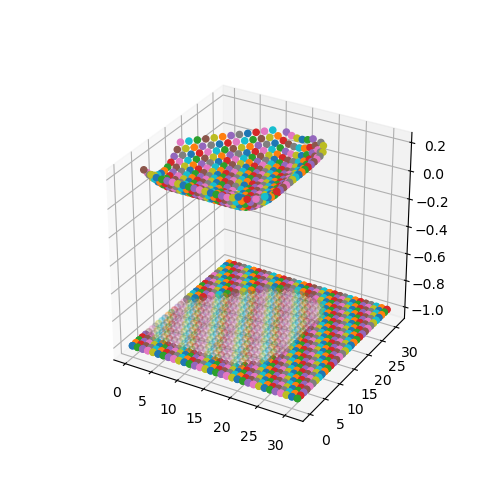

In [246]:
dists = fragments.dists.squeeze().cpu().numpy()
if len(dists.shape) < 3:
    dists = np.expand_dims(dists, axis=2)
print(dists.shape)
plt.figure()
plt.imshow(dists[..., 0])
plt.show()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
for r in range(raster_settings.image_size):
    for c in range(raster_settings.image_size):
        ax.scatter(r, c, dists[r, c, :])
plt.show()

#### prob

<IPython.core.display.Javascript object>


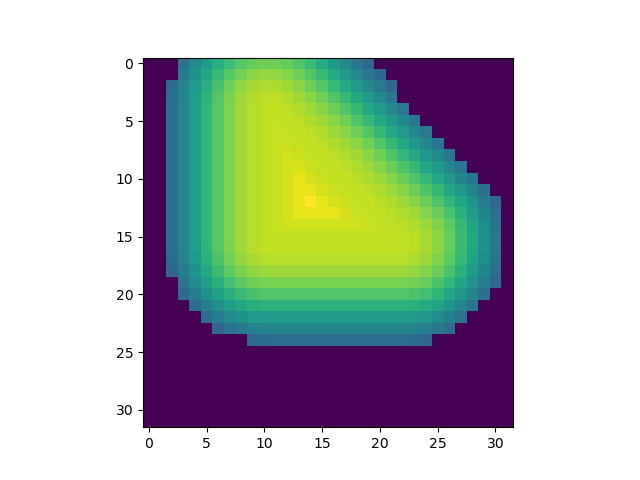

<IPython.core.display.Javascript object>


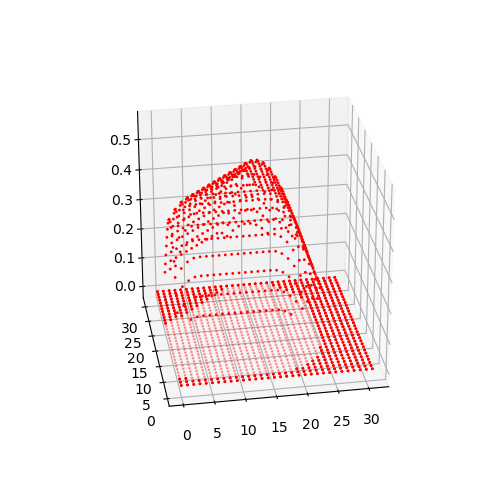

In [212]:
sigma = blend_params.sigma
sigma = 0.2
mask = fragments.pix_to_face >= 0
prob = torch.sigmoid(-fragments.dists / sigma) * mask
prob = prob.squeeze().cpu().numpy()
if len(dists.shape) < 3:
    dists = np.expand_dims(dists, axis=2)
plt.figure()
plt.imshow(prob[..., 0])
plt.show()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
for r in range(raster_settings.image_size):
    for c in range(raster_settings.image_size):
        ax.scatter(r, c, prob[r, c, :], c='r', s=1)

(32, 32, 2) -1.0 2.5394964


<IPython.core.display.Javascript object>


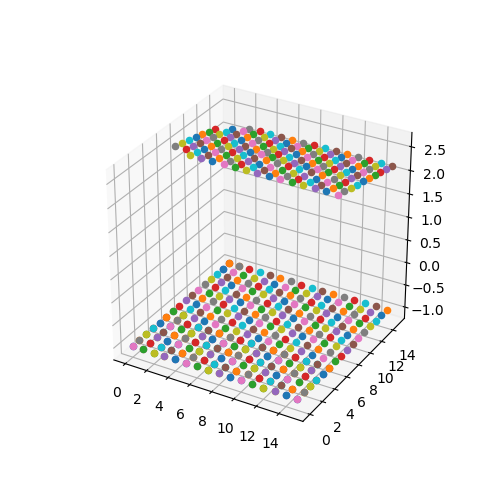

<IPython.core.display.Javascript object>


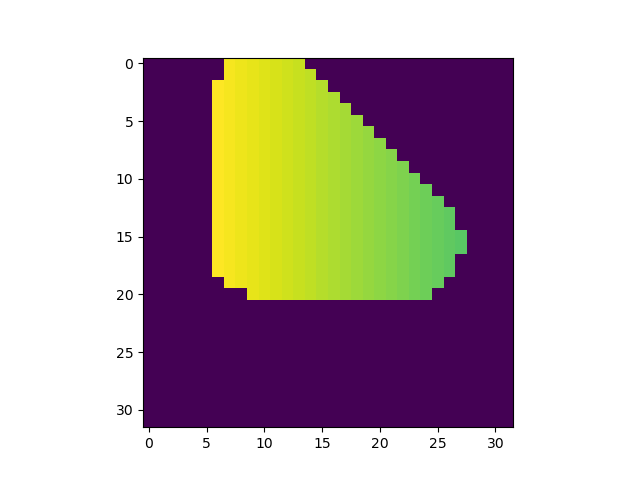

<IPython.core.display.Javascript object>


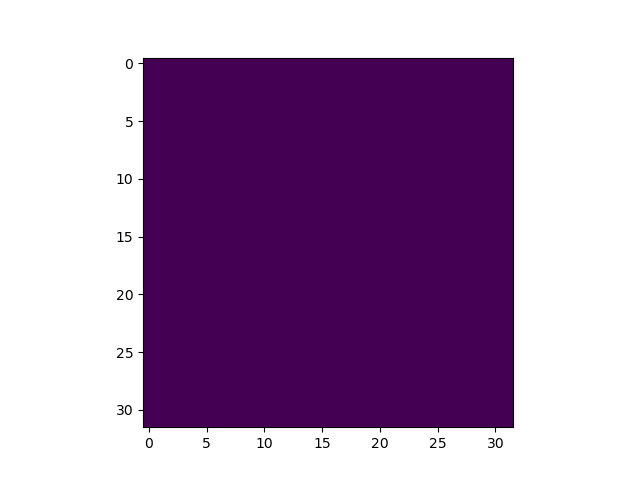

In [204]:
zbuf = fragments.zbuf.squeeze().cpu().numpy()
print(zbuf.shape, np.min(zbuf), np.max(zbuf))
if len(zbuf.shape) < 3:
    zbuf = np.expand_dims(zbuf, axis=2)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
for i in range(zbuf.shape[2]):
    zbufi = zbuf[:, :, i]
    for r in range(16):
        for c in range(16):
            ax.scatter(r, c, zbufi[r, c])
plt.show()
for i in range(zbuf.shape[2]):
    zbufi = zbuf[:, :, i]
    plt.figure()
    plt.imshow(zbufi)
    plt.show()

# Clipping zbuf & bary_coords

[0, 0]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 1]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 2]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 3]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 4]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 5]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 6]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 7]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 8]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 9]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 10]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 11]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 12]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 13]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 14]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[0, 15]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[1, 0]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[1, 1]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[1, 2]: (-1.00, -1.00, -1.00) -> (0.00, 0.00, 0.00)
[1, 3]

<IPython.core.display.Javascript object>


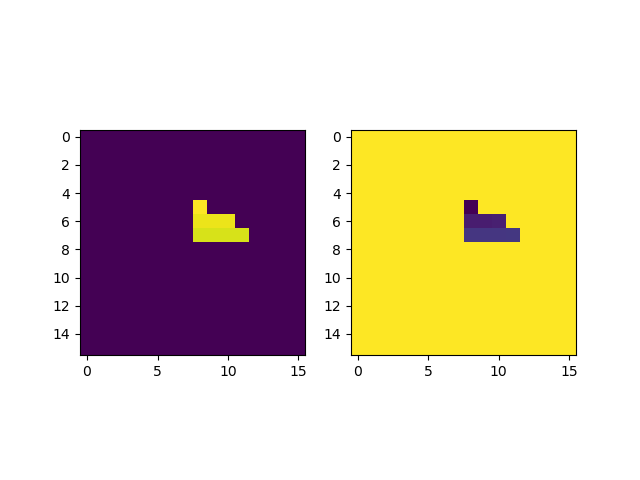

<IPython.core.display.Javascript object>


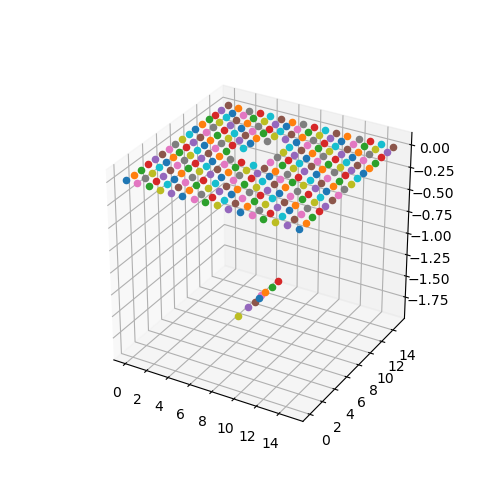

In [109]:
# silhouete, zbuf, zbuf_clipped = silhouette_renderer(meshes_world=mesh, R=R, T=T)
silhouete = silhouette_renderer(meshes_world=mesh, R=R, T=T)
silhouete = silhouete.cpu().numpy()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(zbuf)
ax[1].imshow(zbuf_clipped)
plt.show()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
for r in range(16):
    for c in range(16):
        ax.scatter(r, c, zbuf_clipped[r, c])
plt.show()

# Dist test

tensor(4.)


<IPython.core.display.Javascript object>


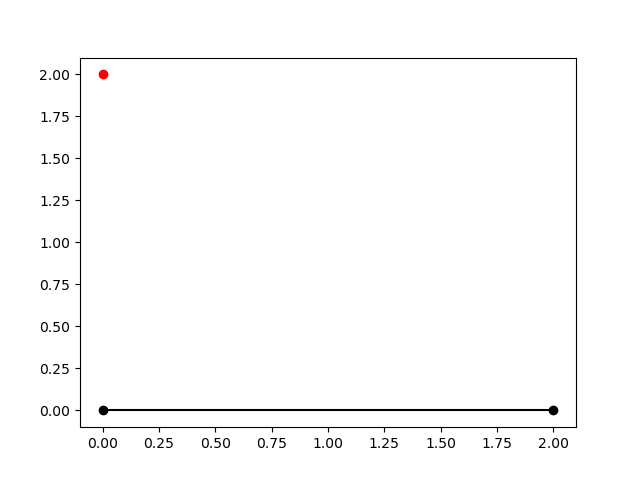

<IPython.core.display.Javascript object>


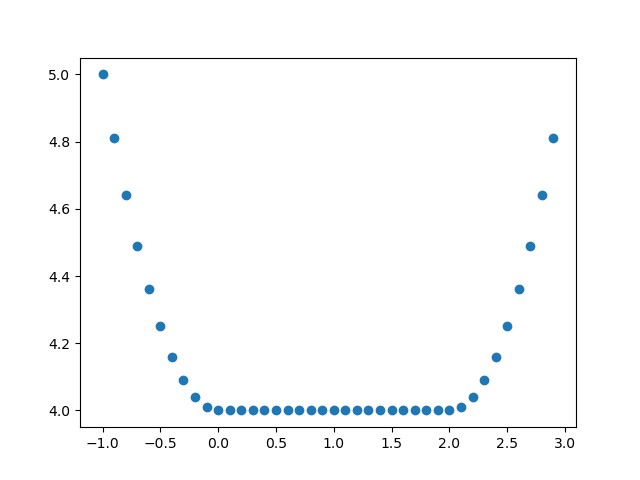

In [240]:
def point_line_distance(p, v0, v1):
    """
    Return minimum distance between line segment (v1 - v0) and point p.

    Args:
        p: Coordinates of a point.
        v0, v1: Coordinates of the end points of the line segment.

    Returns:
        non-square distance to the boundary of the triangle.

    Consider the line extending the segment - this can be parameterized as
    ``v0 + t (v1 - v0)``.

    First find the projection of point p onto the line. It falls where
    ``t = [(p - v0) . (v1 - v0)] / |v1 - v0|^2``
    where . is the dot product.

    The parameter t is clamped from [0, 1] to handle points outside the
    segment (v1 - v0).

    Once the projection of the point on the segment is known, the distance from
    p to the projection gives the minimum distance to the segment.
    """
    if p.shape != v0.shape != v1.shape:
        raise ValueError("All points must have the same number of coordinates")

    v1v0 = v1 - v0
    l2 = v1v0.dot(v1v0)  # |v1 - v0|^2
    if l2 <= kEpsilon:
        return (p - v1).dot(p - v1)  # v0 == v1

    t = (v1v0).dot(p - v0) / l2
    t = torch.clamp(t, min=0.0, max=1.0)
    p_proj = v0 + t * v1v0
    delta_p = p_proj - p
    return delta_p.dot(delta_p)
v0 = torch.from_numpy(np.float32([0, 0]))
v1 = torch.from_numpy(np.float32([2, 0]))
p = torch.from_numpy(np.float32([0, 2]))
dist = point_line_distance(p, v0, v1)
print(dist)
plt.figure()
plt.plot([v0[0], v1[0]], [v0[1], v1[1]], marker='o', c='k')
plt.scatter(p[0], p[1], c='r')
plt.show()

dists = []
xs = []
for i in np.arange(-1, 3, 0.1):
    p = torch.from_numpy(np.float32([i, 2]))
    dist = point_line_distance(p, v0, v1)
    dists.append(dist.squeeze().numpy())
    xs.append(i)
plt.figure()
plt.scatter(xs, dists)
plt.show()

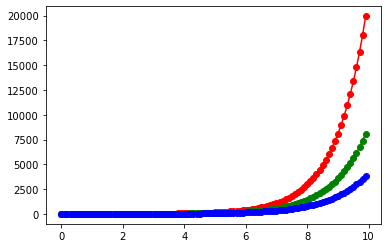

In [3]:
gamma = 0.1
x = np.arange(0, 10, 0.1)

plt.figure()
plt.plot(x, np.exp(x/1), marker='o', c='r')
plt.plot(x, np.exp(x/1.1), marker='o', c='g')
plt.plot(x, np.exp(x/1.2), marker='o', c='b')
plt.show()

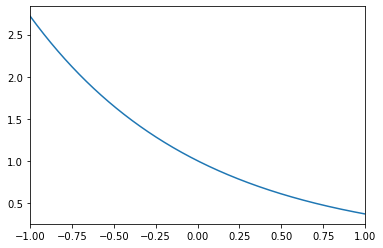

In [17]:
d = np.arange(-1, 1, 0.001)
sigma = 1
A = np.exp(-d/sigma)
plt.figure()
plt.plot(d, A)
plt.xlim([-1, 1])
plt.show()